In [1]:
%matplotlib inline
from src.common.evaluation.pycocotools.coco import COCO
from src.common.evaluation.pycocoevalcap.eval import COCOEvalCap
from src.common.evaluation.get_stanford_models import get_stanford_models
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
import os
import json
from json import encoder

pylab.rcParams['figure.figsize'] = (10.0, 8.0)
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [2]:
# set up file names and pathes
data_dir = os.path.join(os.getcwd(), 'src', 'common', 'evaluation')  # change if you start the notebook-server somewhere else than in the project root dir
data_type = 'val2014'
alg_name = 'fakecap'
ann_file = '%s/demo/captions_%s.json' % (data_dir, data_type)
subtypes = ['results', 'evalImgs', 'eval']
[res_file, eval_imgs_file, eval_file] = ['%s/demo/captions_%s_%s_%s.json' % (data_dir, data_type, alg_name, subtype) for subtype in subtypes]

# download Stanford models
exit_code = get_stanford_models()
if exit_code != 0:
    raise RuntimeError("Stanford Model Download was not successful. Please check log output.")
else:
    print("Standford Model Download successful.")

Standford Model Download successful.


In [3]:
# create coco object and cocoRes object
coco = COCO(ann_file)
coco_res = coco.load_res(res_file)

loading annotations into memory...
0:00:00.199819
creating index...


index created!
Loading and preparing results...     
DONE (t=0.01s)
creating index...
index created!


In [4]:
# create cocoEval object by taking coco and cocoRes
coco_eval = COCOEvalCap(coco, coco_res)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
coco_eval.params['image_id'] = coco_res.get_img_ids()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
coco_eval.evaluate()

tokenization...


setting up scorers...
computing ['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4'] score...


{'testlen': 9893, 'reflen': 9855, 'guess': [9893, 8893, 7893, 6893], 'correct': [5732, 2510, 1043, 423]}
ratio: 1.003855910705124
Bleu_1: 0.579
Bleu_2: 0.404
Bleu_3: 0.279
Bleu_4: 0.191
computing ROUGE_L score...
ROUGE_L: 0.396
computing CIDEr score...


CIDEr: 0.600
computing SPICE score...


SPICE: 0.133


In [5]:
# print output evaluation scores
for metric, score in coco_eval.eval.items():
    print('%s: %.3f' % (metric, score))

Bleu_1: 0.579
Bleu_2: 0.404
Bleu_3: 0.279
Bleu_4: 0.191
ROUGE_L: 0.396
CIDEr: 0.600
SPICE: 0.133


ground truth captions
A man with a red helmet on a small moped on a dirt road. 
Man riding a motor bike on a dirt road on the countryside.
A man riding on the back of a motorcycle.
A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
A man in a red shirt and a red hat is on a motorcycle on a hill side.


generated caption (CIDEr score 0.1)
man holding a red umbrella in the rain


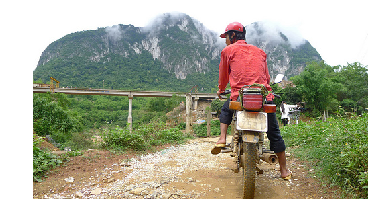

In [6]:
# demo how to use evalImgs to retrieve low score result
evals = [eva for eva in coco_eval.eval_imgs if eva['CIDEr'] < 30]
print('ground truth captions')
img_id = evals[0]['image_id']
ann_ids = coco.get_ann_ids(img_ids=img_id)
anns = coco.load_anns(ann_ids)
coco.show_anns(anns)

print('\n')
print('generated caption (CIDEr score %0.1f)' % (evals[0]['CIDEr']))
ann_ids = coco_res.get_ann_ids(img_ids=img_id)
anns = coco_res.load_anns(ann_ids)
coco.show_anns(anns)

img = coco.load_imgs(img_id)[0]
loaded_image = io.imread(img['url'])
plt.imshow(loaded_image)
plt.axis('off')
plt.show()

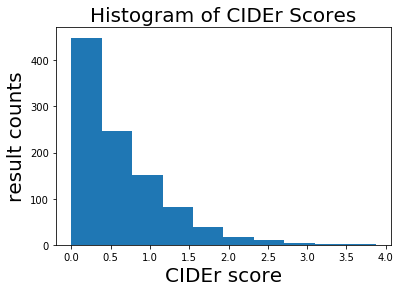

In [7]:
# plot score histogram
cider_scores = [eva['CIDEr'] for eva in coco_eval.eval_imgs]
plt.hist(cider_scores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

In [8]:
# save evaluation results to ./results folder
json.dump(coco_eval.eval_imgs, open(eval_imgs_file, 'w'))
json.dump(coco_eval.eval, open(eval_file, 'w'))